In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/data_2015.csv')
townships = gpd.read_file('../data/township_geom/gwr_townships.shp')

In [3]:
# Convert code column to integer
townships['TOWNCODE'] = townships['TOWNCODE'].astype(int) 

# Merge data with township geom
tw = townships.merge(data, left_on='TOWNCODE', right_on='code', how='left')
tw.drop(['TOWNCODE', 'COUNTYCODE', 'TOWNENG'], axis=1, inplace=True)

# Find centroid coordinates
tw['X'] = tw.centroid.x
tw['Y'] = tw.centroid.y

#tw.head()

In [4]:
# Prepare inputs
tw_y = tw['dengue_per_10k'].values.reshape((-1, 1)) # y – dependent variable
expl_variables = ['tmax', 'precip', 'pop_density']  # ['tavg', 'tmax', 'precip', 'pop_density', 'elevation', 'built_up_area']
tw_X = tw[expl_variables].values # X – matrix of explanatory variables
u = tw['X']
v = tw['Y']
tw_coords = list(zip(u, v)) # polygon centroid coordinates

In [5]:
# Standardisation
tw_X = (tw_X - tw_X.mean(axis=0)) / tw_X.std(axis=0)
tw_y = (tw_y - tw_y.mean(axis=0)) / tw_y.std(axis=0)

#tw_y = np.sqrt(tw_y) # transformation for right-skewed dist

In [6]:
# Select bandwidth for GWR model
bw_selector = Sel_BW(tw_coords, tw_y, tw_X)
gwr_bw = bw_selector.search()
print(gwr_bw)

60.0


In [7]:
# Fit GWR model
gwr_model = GWR(tw_coords, tw_y, tw_X, gwr_bw, name_x=expl_variables).fit()
gwr_model.summary()

Model type                                                         Gaussian
Number of observations:                                                 349
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            325.498
Log-likelihood:                                                    -483.044
AIC:                                                                974.088
AICc:                                                               976.263
BIC:                                                              -1694.502
R2:                                                                   0.067
Adj. R2:                                                              0.059

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [8]:
# Select bandwidth for MGWR model
bw_selector = Sel_BW(tw_coords, tw_y, tw_X, multi=True) 
mgwr_bw = bw_selector.search()
print(mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 57. 347. 347.  57.]


In [9]:
# Fit MGWR model
mgwr_model = MGWR(tw_coords, tw_y, tw_X, bw_selector, name_x=expl_variables).fit()
mgwr_model.summary()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 349
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            325.498
Log-likelihood:                                                    -483.044
AIC:                                                                974.088
AICc:                                                               976.263
BIC:                                                              -1694.502
R2:                                                                   0.067
Adj. R2:                                                              0.059

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### Record results into dataframe

In [10]:
# Create an empty datafarame for diagnostics
column_names = ['model', 'variable', 'bandwidth', 'ENP', 'AICc', 'R2', 'adj_R2', 'adj_alpha', 'adj_tval']
diagnostics = pd.DataFrame(columns=column_names)

In [11]:
# Insert model results
diagnostics.loc[0] = [
                        'gwr', # model 
                        np.nan, # explanatory variable or entire model
                        gwr_bw, # bandwidth
                        gwr_model.ENP, # effective number of parameters
                        gwr_model.aicc, # corrected Akaike Information Criterion
                        gwr_model.R2, # R-squared
                        gwr_model.adj_R2, # adjusted R-squared
                        gwr_model.adj_alpha[1], # adjusted alpha (95%)
                        gwr_model.critical_tval() # adjusted t-value (95%)
]
diagnostics.loc[1] = ['mgwr', np.nan, np.nan, mgwr_model.ENP, mgwr_model.aicc, mgwr_model.R2, mgwr_model.adj_R2, mgwr_model.adj_alpha[1], mgwr_model.critical_tval(mgwr_model.adj_alpha[1])]
diagnostics.loc[2] = ['mgwr', 'intercept', mgwr_bw[0], mgwr_model.ENP_j[0], np.nan, np.nan, np.nan, mgwr_model.adj_alpha_j[0][1], mgwr_model.critical_tval()[0]]

for i in range(len(expl_variables)):
    diagnostics.loc[i+3] = ['mgwr', expl_variables[i], mgwr_bw[i+1], mgwr_model.ENP_j[i+1], np.nan, np.nan, np.nan, mgwr_model.adj_alpha_j[i+1][1], mgwr_model.critical_tval()[i+1]]

diagnostics

model     variable  bandwidth        ENP        AICc        R2    adj_R2  \
0   gwr          NaN       60.0  43.069884  512.242697  0.809886  0.783034   
1  mgwr          NaN        NaN  26.322763  499.222273  0.793581  0.776690   
2  mgwr    intercept       57.0  13.476599         NaN       NaN       NaN   
3  mgwr         tmax      347.0   1.417689         NaN       NaN       NaN   
4  mgwr       precip      347.0   1.406365         NaN       NaN       NaN   
5  mgwr  pop_density       57.0  10.022110         NaN       NaN       NaN   

   adj_alpha  adj_tval  
0   0.004644  2.849210  
1   0.007598  2.685100  
2   0.003710  2.921572  
3   0.035269  2.113507  
4   0.035553  2.110220  
5   0.004989  2.825770

#### Visualise (M)GWR results

Text(0.5, 1.0, 'MGWR Standardised Residuals')

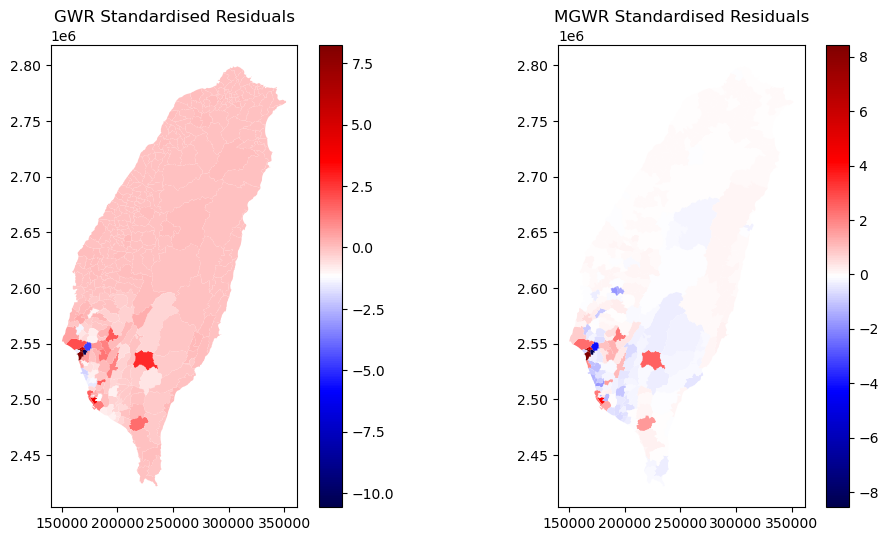

In [12]:
# Plot standardised residuals
f, ax = plt.subplots(1, 2, figsize=(12,6))

# GWR
tw['gwr_std_res'] = gwr_model.std_res
tw.plot('gwr_std_res', legend = True, ax=ax[0], cmap='seismic')

# MGWR
# Standardized residuals without influence matrix
std_residuals = mgwr_model.resid_response.reshape((-1, 1)) / np.std(mgwr_model.resid_response)
tw['mgwr_std_res'] = std_residuals
tw.plot('mgwr_std_res', legend = True, ax=ax[1], cmap='seismic')

ax[0].set_title("GWR Standardised Residuals")
ax[1].set_title("MGWR Standardised Residuals")

In [13]:
# Inserlt local parameter estimates into dataframe
# GWR
tw['gwr_intercept'] = gwr_model.params[:,0]
for i in range(len(expl_variables)):
    tw['gwr_' + expl_variables[i]] = gwr_model.params[:,i+1]

# MGWR
tw['mgwr_intercept'] = mgwr_model.params[:,0]
for i in range(len(expl_variables)):
    tw['mgwr_' + expl_variables[i]] = mgwr_model.params[:,i+1]

# Find insignificant values for masking
gwr_filtered_t = gwr_model.filter_tvals()
mgwr_filtered_t = mgwr_model.filter_tvals()

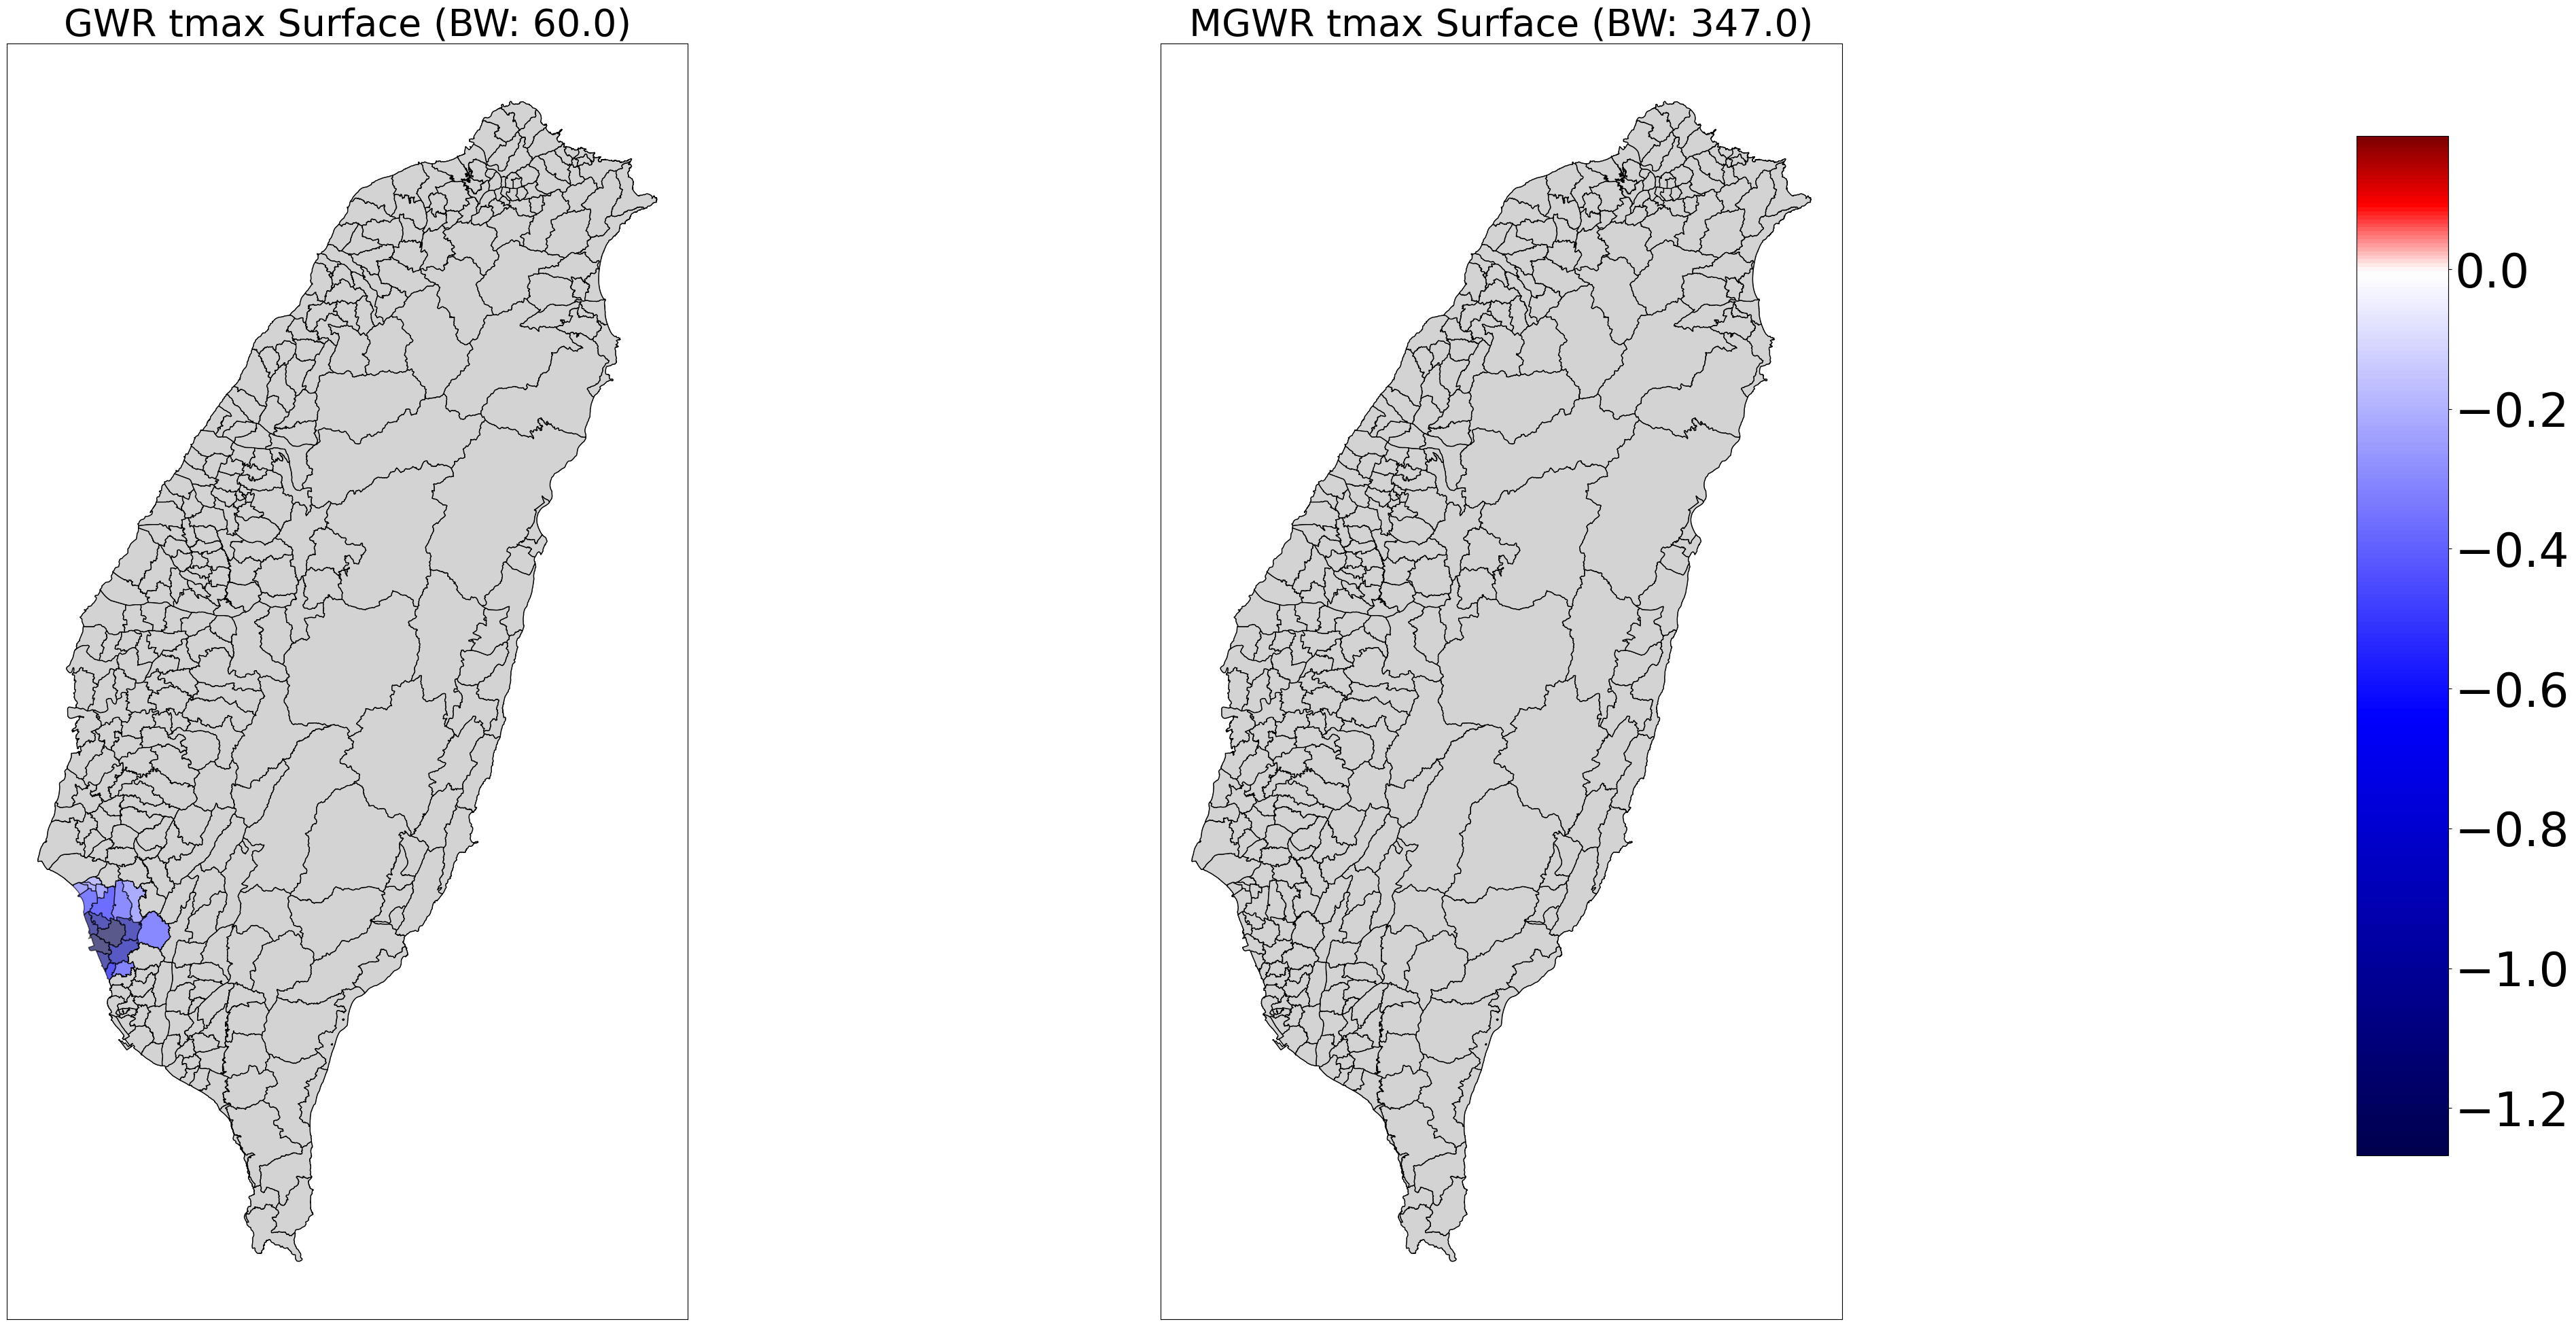

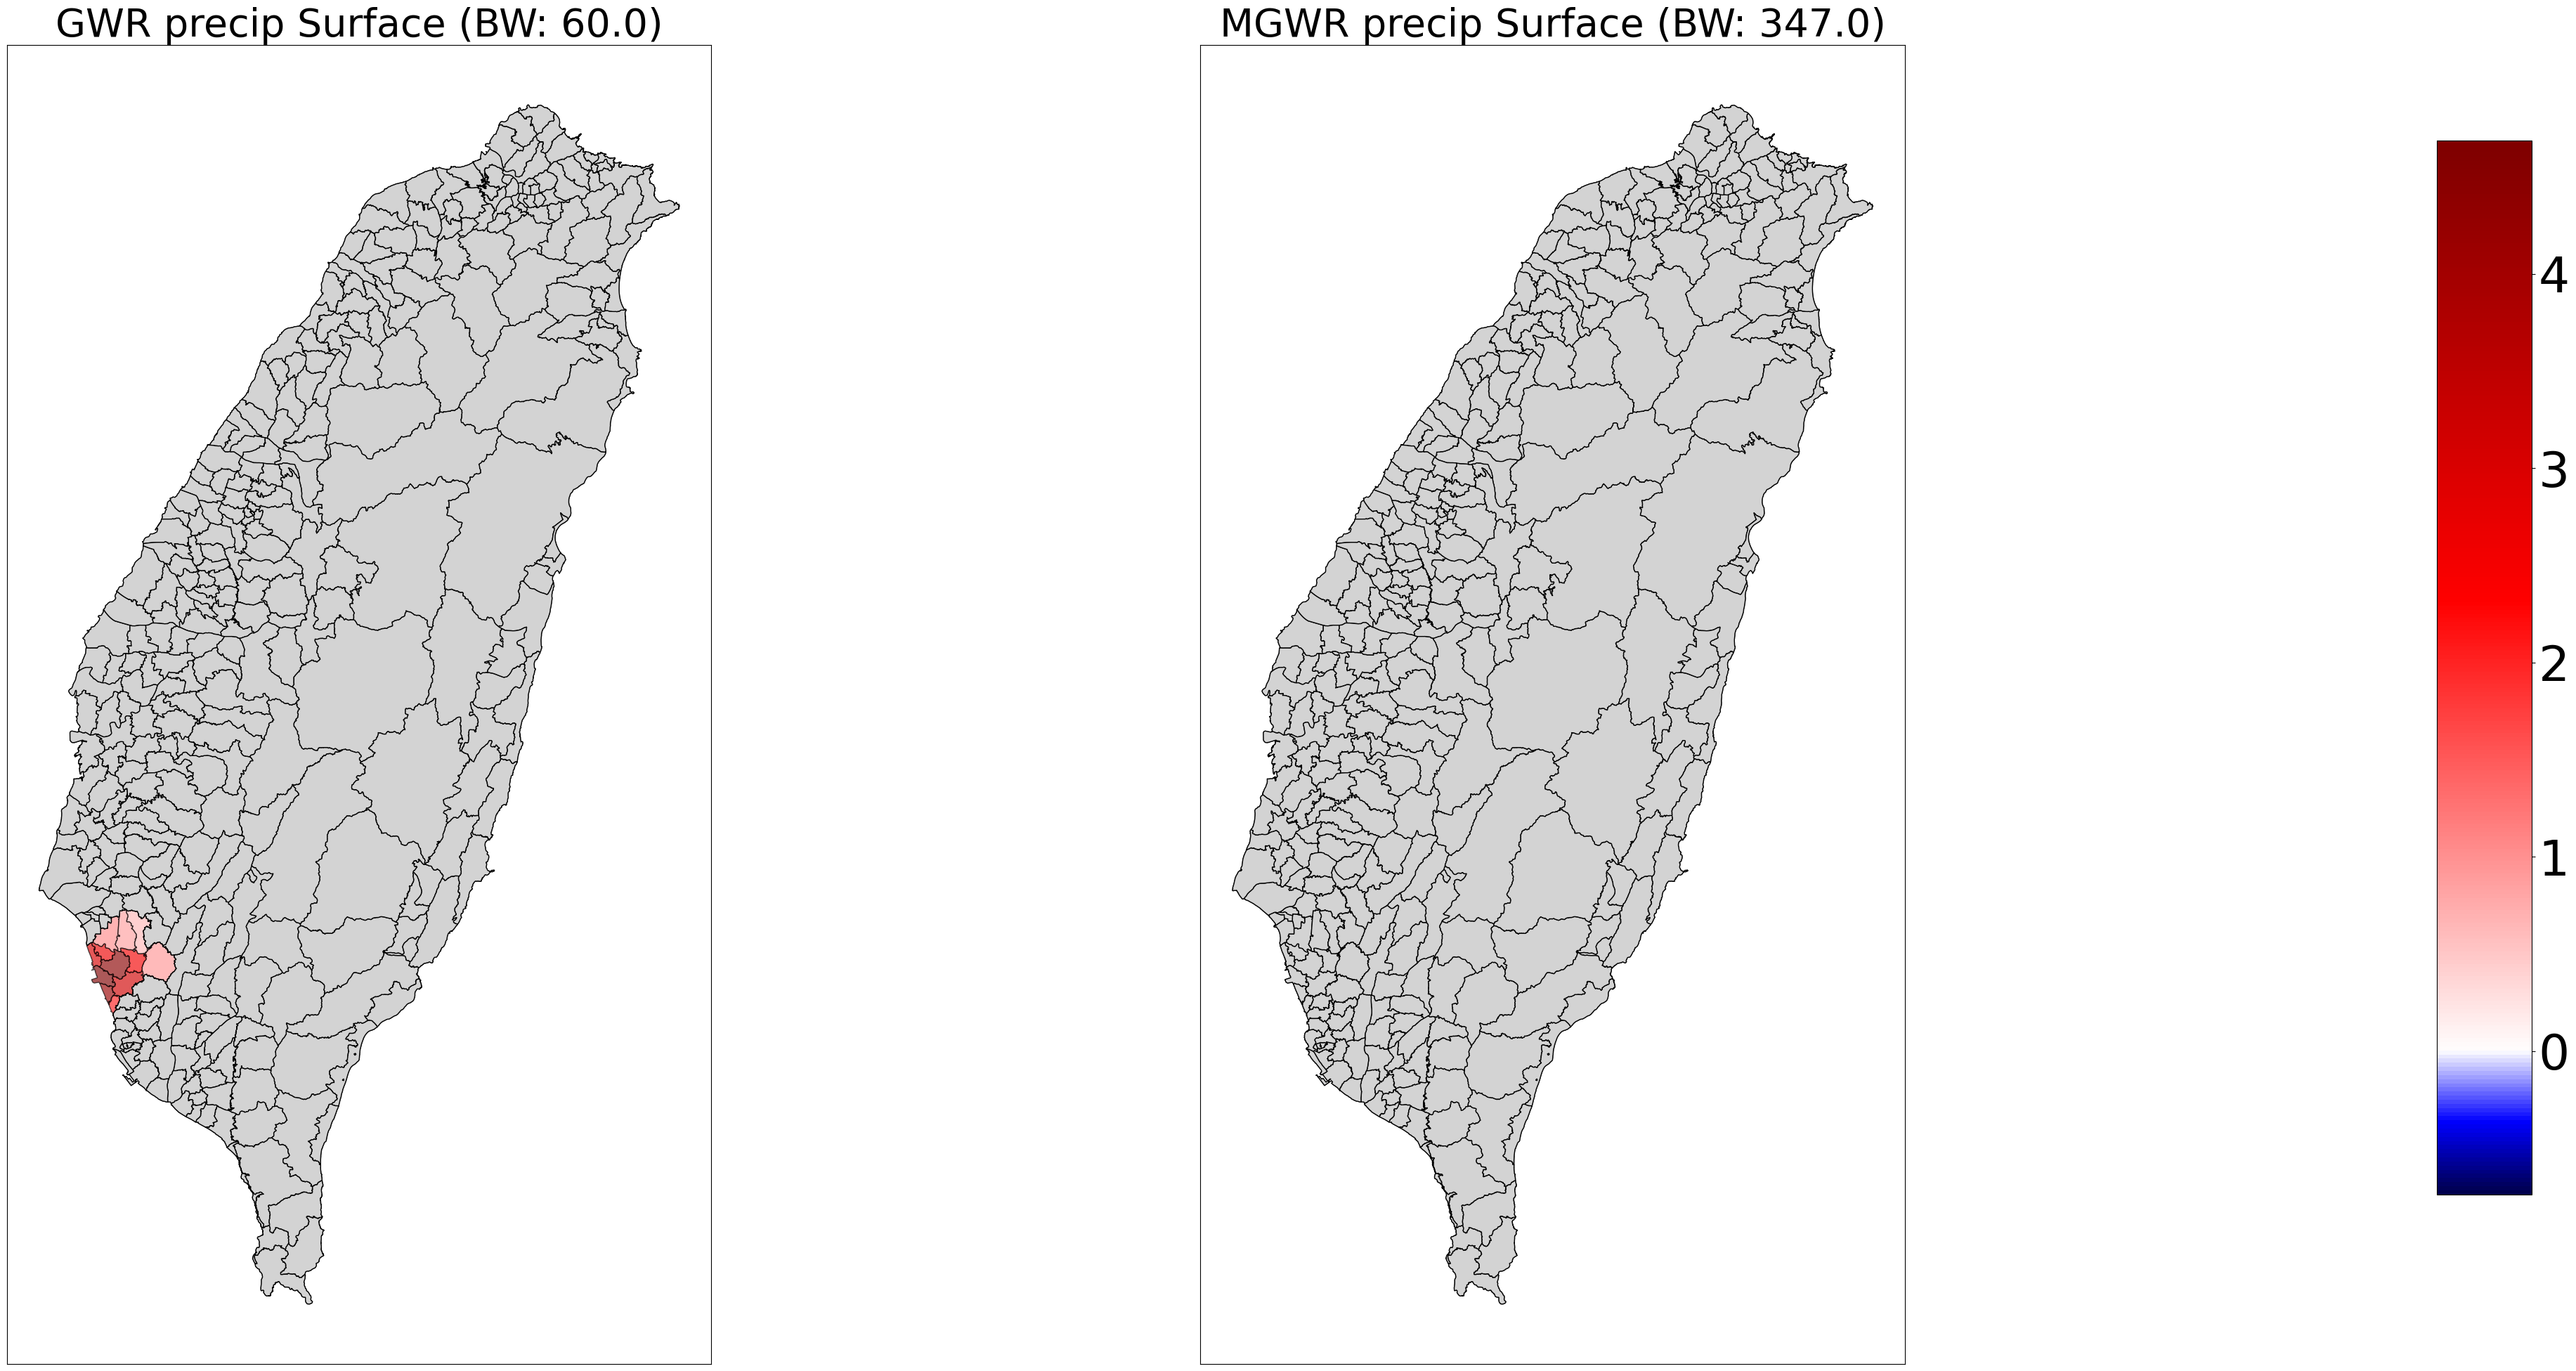

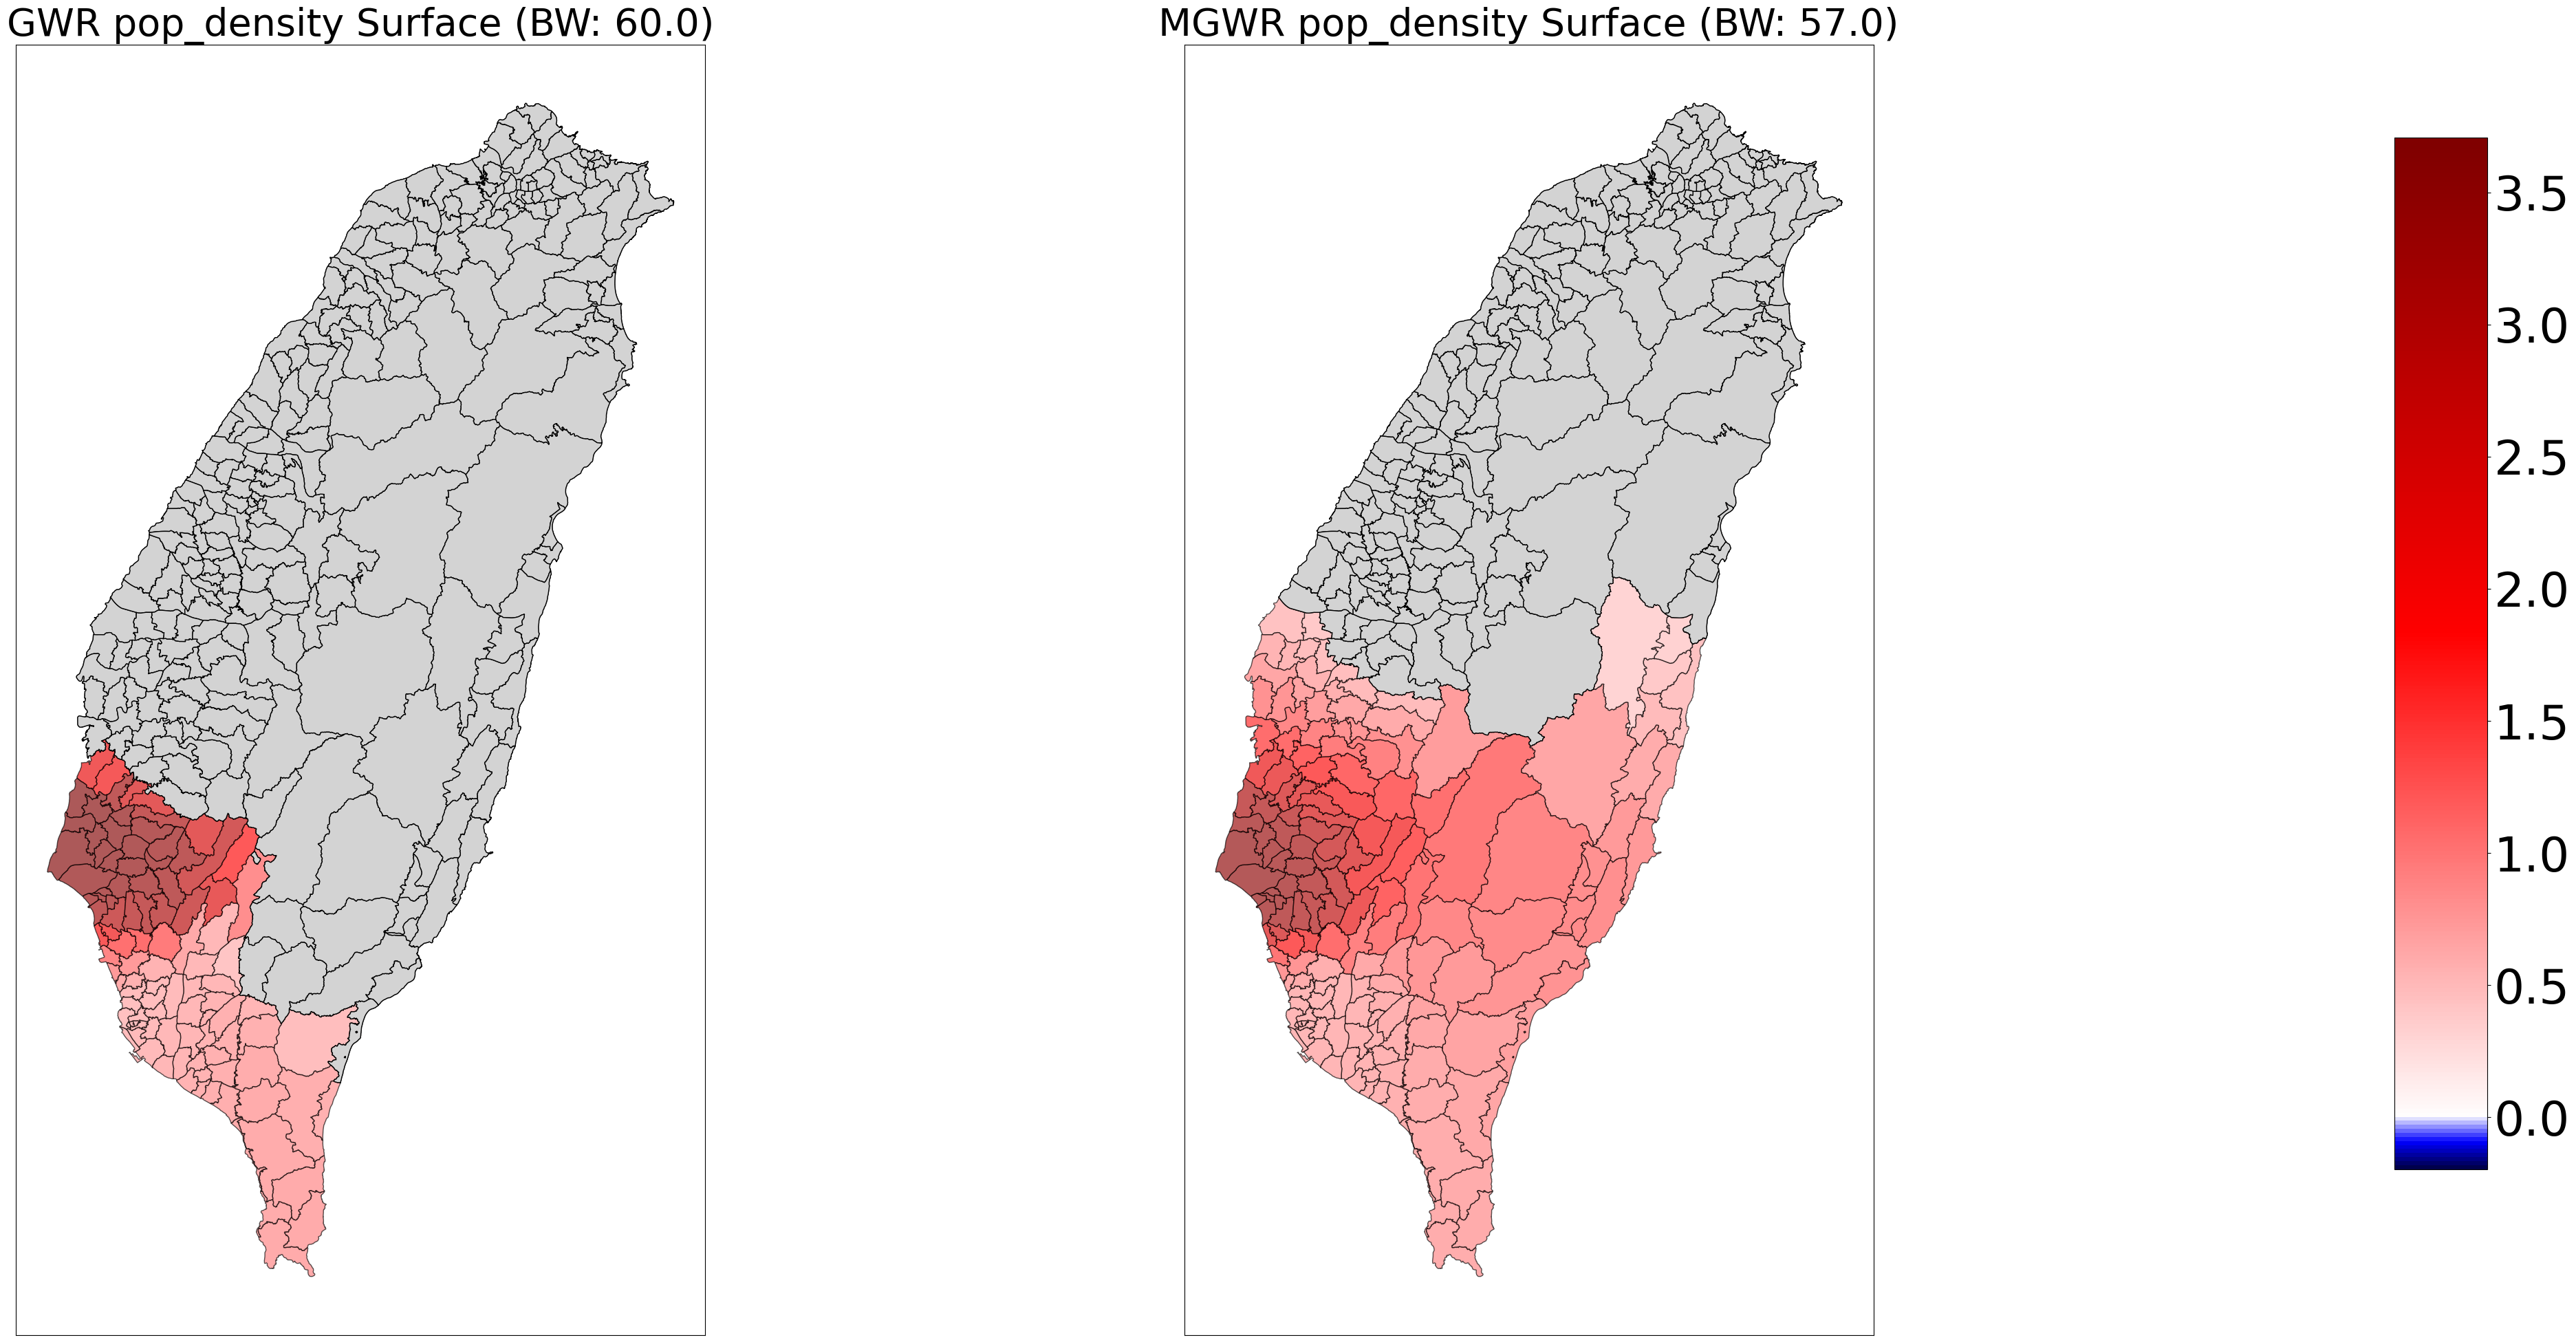

In [14]:
kwargs1 = {'edgecolor': 'black', 'alpha': .65}
kwargs2 = {'edgecolor': 'black'}

for i in range(len(expl_variables)):
    gwr_variable = 'gwr_' + expl_variables[i]
    mgwr_variable = 'mgwr_' + expl_variables[i]
    compare_surfaces(tw, 
                    gwr_variable, 
                    mgwr_variable,
                    gwr_filtered_t[:, i+1], 
                    gwr_bw, 
                    mgwr_filtered_t[:, i+1],
                    mgwr_bw[i+1], 
                    expl_variables[i], 
                    kwargs1, 
                    kwargs2)

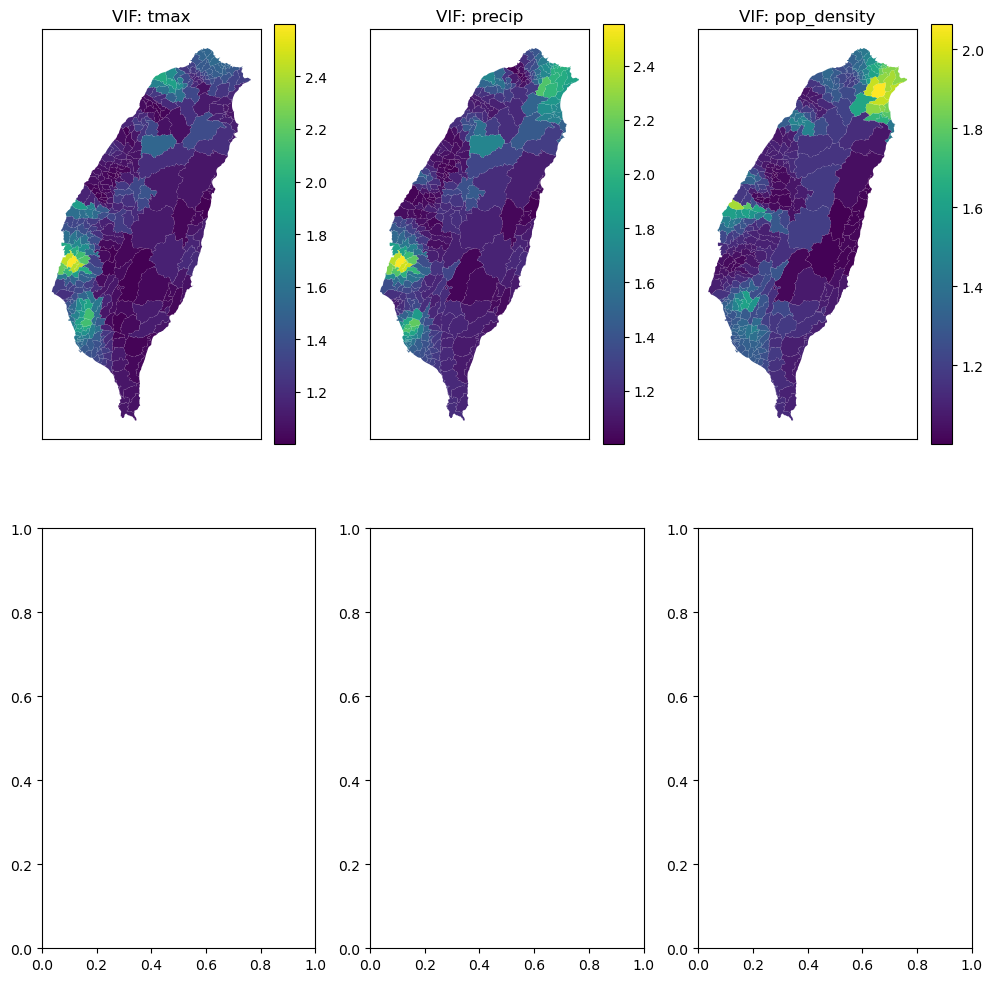

In [15]:
# Plot local multicollinearity
LCC, VIF, CN, VDP = gwr_model.local_collinearity()

# Local variance inflation factor (VIF)
f, ax = plt.subplots(2, 3, figsize = (12, 12))
axes = ax.flatten()

for col in range(len(expl_variables)):
   tw['vif_' + expl_variables[col]] = VIF[:, col]
   tw.plot(('vif_' + expl_variables[col]), ax = axes[col], legend = True)
   axes[col].set_title('VIF: ' + expl_variables[col])
   axes[col].get_xaxis().set_visible(False)
   axes[col].get_yaxis().set_visible(False)